<a href="https://colab.research.google.com/github/TYH71/DELE_CA1/blob/main/Part%20A/2.%20Baseline%20Implementation%20w%20Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST - Baseline ConvNet w/ Image Augmentation

- Name: Tan Yu Hoe
- Admin No: P2026309
- Class: DAAA/FT/2B/04

## Motivation

This notebook is purposed to train and evaluate a Convolution Neural Network on CIFAR-10 dataset, implementing Image Augmentation. Experimentation results are run and stored in **Weights and Biases**.

## Personal Objectives

These are objectives / goals for myself to accomplish while attempting to perform image classification for the Fashion MNIST dataset.

1. Obtain a high test accuracy compared to public benchmark (The average benchmark for Fashon MNIST is about 90% Test Accuracy)
2. Experiment with multiple training strategies and CNN architectures

## !! Important Note !!

As this is an experimentation run, I would not go so in depth into Exploratory Data Analysis, Image Processing, and the Neural Network Archtecture ( Using a Baseline ConvNet ) itself. The markdown headers are used as checkpoints for me to better navigate around the notebook using Google Colaboratory.


In [28]:
# import relevant libraries/classes/dependencies
import os
import random

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
import datetime
!pip install -q pytz
import pytz
sg = pytz.timezone("Singapore")

# Set the random seeds - to ensure reproducibility
os.environ['TF_CUDNN_DETERMINISTIC'] = "1"
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [29]:
# Matplotlib Stylings
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.autolayout'] = True
plt.style.use('fivethirtyeight')

## Setting up **Weights and Biases**


In [30]:
# install and configure weights and biases
!pip install -q wandb
import wandb
from wandb.keras import WandbCallback
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

## Training on a Tesla P100-PCIE-16GB


In [31]:
!nvidia-smi

Tue Nov 23 13:10:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    36W / 250W |   5057MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [32]:
# Checking if GPU is available
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17361668892994349834
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16154099712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10020328075595941970
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


## Data Injestion

In [33]:
# Import Dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', "Coat", "Sandle", 'Shirt', 'Sneaker', 'Bag', 'Ankle Boots']
print('Dataset Loaded')

Dataset Loaded


In [34]:
# Shape of Training and Testing Sets
print("X_train:", x_train.shape, "y_train:", y_train.shape)
print("X_test:", x_test.shape, "y_test:", y_test.shape)

X_train: (60000, 28, 28) y_train: (60000,)
X_test: (10000, 28, 28) y_test: (10000,)


## Feature Engineering


In [35]:
# Import Keras Functions
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.utils import plot_model
from tensorflow.nn import local_response_normalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [36]:
def preprocessing_func(x, y):
    # preprocess X
    x = x.reshape((-1, 28, 28, 1))
    x = tf.cast(x, tf.float32)
    x = tf.image.grayscale_to_rgb(x)
    x = Rescaling(1./127.5, offset=-1)(x)

    return x, y

# transform 
x_train, y_train = preprocessing_func(x_train, y_train)
x_test, y_test = preprocessing_func(x_test, y_test)

print("Training Shape:", x_train.shape, y_train.shape)
print("Testing Shape:", x_test.shape, y_test.shape)


Training Shape: (60000, 28, 28, 3) (60000,)
Testing Shape: (10000, 28, 28, 3) (10000,)


## Image Augmentation

Let's do a quick google search and look for the definition of image augmentation.

> Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset. ... Image data augmentation is used to expand the training dataset in order to improve the performance and ability of the model to generalise. [[Source](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)]

Convolution Neural Networks has an ability to greatly generalise/capture the underlying structure of the training images provided. This creates a tendency of overfitting in the model, having a large variance between the training and validation data provided.

By using Image Augmentation, we create more variations of the training images provided, improving the performance of the model of better generalisation. The Keras API provides us a class `ImageDataGenerator` to easily perform image augmentation by generating batches of augmented image tensors. 

|![](https://qph.fs.quoracdn.net/main-qimg-9b617d0b411ed818b5d512afacf81bbd)|
|:--:|
| Illustration of Image Augmentation on MNIST Digits Dataset |

### Cutout / Random Erasing

Cutout or Random Erasing is a kind of image augmentation methods for ConvNet. It tries to regularize models using training images that are randomly masked with random values. [1][2]

By generating images with random masks, it better prepares the models by learning to take more features of the images into consideration before making an prediction/ouptut.

The Keras/Tensorflow does not provide any classes/function (or not that I know of) to do random Cutout in images. Thus, I sourced for the function in a GitHub repository to do this for me. Then, I integrate this function within the `ImageDataGenerator` class along with other types of augmentation.

```py
## source code: https://github.com/yu4u/mixup-generator/blob/master/random_eraser.py
get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255)

"""
Args:
- p : the probability that random erasing is performed
- s_l, s_h : minimum / maximum proportion of erased area against input image
- r_1, r_2 : minimum / maximum aspect ratio of erased area
- v_l, v_h : minimum / maximum value for erased area
```
|![Animated Illustration of Cutout / Random Erasing](https://raw.githubusercontent.com/zhunzhong07/Random-Erasing/master/img/002-black.gif)|
|:--:|
| Animated Illustration of Cutout / Random Erasing |

---

- [1] T. DeVries and G. W. Taylor, "Improved Regularization of Convolutional Neural Networks with Cutout," in arXiv:1708.04552, 2017.
- [2] Z. Zhong, L. Zheng, G. Kang, S. Li, and Y. Yang, "Random Erasing Data Augmentation," in arXiv:1708.04896, 2017.

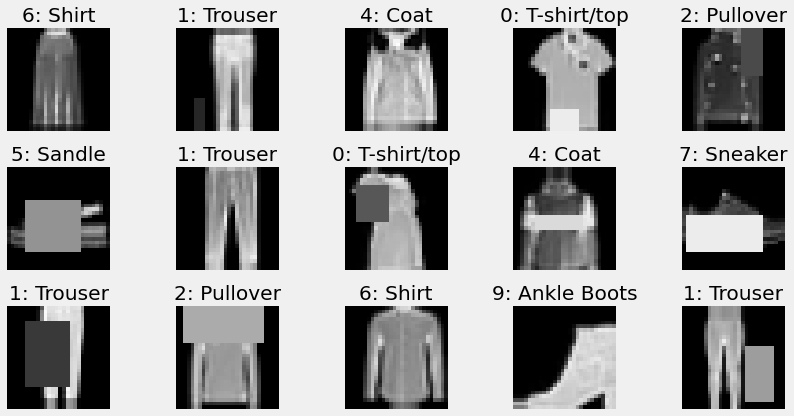

In [37]:
## source code: https://github.com/yu4u/mixup-generator/blob/master/random_eraser.py
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255):
    def eraser(input_img):
        img_h, img_w, _ = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        c = np.random.uniform(v_l, v_h)
        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

# prepare image data generator for augmentation
train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    preprocessing_function=get_random_eraser(v_l=-1, v_h=1),
    validation_split=0.1,
)

# display images from
example_ds = train_datagen.flow(x=x_train, y=y_train)
fig = plt.figure()
for i in range(15):
    img, label = example_ds.next()
    ax = fig.add_subplot(3, 5, i+1)
    ax.imshow((img[0] + 1) / 2)
    ax.set_title(f"{label[0]}: {classes[label[0]]}")
    ax.axis('off')
plt.show()

## Baseline Model w/ Image Augmentation

For the model, I did not make any change to the baseline ConvNet I've implemented earlier on. I intend to run experiementation tracking to do a comparison between the baseline architecture with/without Image Augmentation.


In [38]:
def conv_block(neurons: int, num: int):
    '''
    Creates a generic Hidden Conv2D Layer with ReLU Activations
    Including Batch Normalization and Max Pooling Layers
    
    Args:
        - neurons: number of neurons in the dense layer
        - num    : block number
        - kernel size: height and width of Convolution 2D window (k, k)
          - default: 3
    '''
    block = Sequential(name=f'Covolution_Block_{num}')
    block.add(Conv2D(neurons, kernel_size=(3, 3),
                     activation='relu', strides=1, padding='same', kernel_initializer='he_normal'))
    block.add(BatchNormalization())
    block.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

    return block


In [39]:
# Densely Connected Blocks
def dense_block(neurons: int, num: int, dropout:float):
    '''
    Creates a generic Hidden Dense Layer with ReLU Activations
    Including Dropout and Batch Normalization layers
    
    Args:
        - neurons: number of neurons in the dense layer
        - num    : block number
        - dropout: proportion of weights to apply dropout
    '''
    block = Sequential(name=f'Dense_Block_{num}')
    block.add(Dense(neurons, activation='relu', kernel_initializer='he_normal'))
    block.add(BatchNormalization())
    block.add(Dropout(dropout))

    return block

In [40]:
def baseline_builder(input_shape=(28, 28, 3)):
    model = Sequential(name='Baseline')
    
    # Input and Feature Engineering
    model.add(Input(input_shape, name='Input_Layer'))
    
    # Convolutional Block - Feature Extraction
    for layer_num in range(1):
        model.add(conv_block(64, layer_num))
    
    # Flatten Layer - the middle layer between convolutional and densely connected layers
    model.add(Flatten(name='Flatten'))

    # Densely Connected Nodes - Classification Block
    for layer_num in range(1):
        model.add(dense_block(64, layer_num, 0.5))

    # Output Layer - Softmax Activation
    model.add(Dense(10, activation='softmax', name='Softmax_Output_Layer'))
    
    return model

## Model Configuration and Building

Most of the model's hyperparameters (eg. batch size, learning rate) are stored within a configuration class within **Weights and Biases**.

In [41]:
# Intiate Weights and Biases run
current_time = datetime.datetime.now(sg).strftime("%d:%m:%Y_%H:%M")
run = wandb.init(
    project="Fashion MNIST ConvNet",
    name=f"Baseline_ConvNet w/ Augmentation {[current_time]}",
    config={
        "learning_rate": 0.001,
        "epochs": 50,
        "batch_size": 512,
        "loss_function": "sparse_categorical_crossentropy",
        "architecture": "Baseline ConvNet",
        "dataset": "Fashion MNIST"
    },
    group="Baseline ConvNet w/ Image Augmentation"
)

# Prepare Configurations
config = wandb.config

# Build the Network
tf.keras.backend.clear_session() # Resets all state generated by Keras
baseline = baseline_builder()
baseline.summary()

# Preparing Optimizer
optimizer = Adam(learning_rate=config.learning_rate)

# Compiling - Adam Optimizer Categorical Cross Entropy Loss Function
baseline.compile(
    optimizer=optimizer, 
    loss=config.loss_function, 
    metrics=['accuracy']
)

accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▂▂▆▆▇▆▇▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██▇▇██▇██▇▇▇███
val_loss,█▆▇▆▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁
accuracy,0.84587
best_epoch,49
best_val_loss,0.35515
epoch,49
loss,0.42951
val_accuracy,0.87183


Model: "Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Covolution_Block_0 (Sequent  (None, 14, 14, 64)       2048      
 ial)                                                            
                                                                 
 Flatten (Flatten)           (None, 12544)             0         
                                                                 
 Dense_Block_0 (Sequential)  (None, 64)                803136    
                                                                 
 Softmax_Output_Layer (Dense  (None, 10)               650       
 )                                                               
                                                                 
Total params: 805,834
Trainable params: 805,578
Non-trainable params: 256
_________________________________________________________________


In [42]:
# Final Set of Callbacks
callbacks = [
    WandbCallback(save_model=True) # integrated keras callback function by Weights and Biases
]

In [43]:
%%time
# Train Model
baseline_hist = baseline.fit(
      train_datagen.flow(x_train, y_train, subset='training', batch_size=config.batch_size), 
      validation_data=train_datagen.flow(x_train, y_train, subset='validation', batch_size=config.batch_size),
      epochs=config.epochs,
      verbose=1,
      use_multiprocessing=True,
      workers=32,
      callbacks=callbacks
)
run.finish()

Epoch 1/50
106/106 [==============================] - 22s 177ms/step - loss: 1.1257 - accuracy: 0.6126 - val_loss: 0.9628 - val_accuracy: 0.6895
Epoch 2/50
106/106 [==============================] - 22s 174ms/step - loss: 0.8184 - accuracy: 0.7069 - val_loss: 0.7803 - val_accuracy: 0.7290
Epoch 3/50
106/106 [==============================] - 21s 169ms/step - loss: 0.7234 - accuracy: 0.7401 - val_loss: 0.8420 - val_accuracy: 0.6900
Epoch 4/50
106/106 [==============================] - 24s 191ms/step - loss: 0.6627 - accuracy: 0.7622 - val_loss: 0.7148 - val_accuracy: 0.7517
Epoch 5/50
106/106 [==============================] - 21s 171ms/step - loss: 0.6383 - accuracy: 0.7711 - val_loss: 0.6146 - val_accuracy: 0.7728
Epoch 6/50
106/106 [==============================] - 21s 170ms/step - loss: 0.5981 - accuracy: 0.7824 - val_loss: 0.6381 - val_accuracy: 0.7680
Epoch 7/50
106/106 [==============================] - 24s 191ms/step - loss: 0.5804 - accuracy: 0.7910 - val_loss: 0.5250 - val_ac

accuracy,▁▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▁▃▄▆▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇██▇▇▇█▇███▇▇██▇▇███
val_loss,█▆▇▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▂▁▁▂▂▁▁▁
accuracy,0.84781
best_epoch,42
best_val_loss,0.35568
epoch,49
loss,0.42187
val_accuracy,0.86867


CPU times: user 2min 34s, sys: 7min 43s, total: 10min 18s
Wall time: 22min 15s


In [44]:
# in case of model training being interrupted
run.finish()

## Model Evaluation

Why k-fold cross validation is not feasible in neural networks? There are too many data and it is computationally expensive to train a neural network, usually k-fold cross validation is often disregarded when training a neural network.

Here, I just passed the training and testing set in for evaluation, then store the results, log loss and accuracy, in a DataFrame.



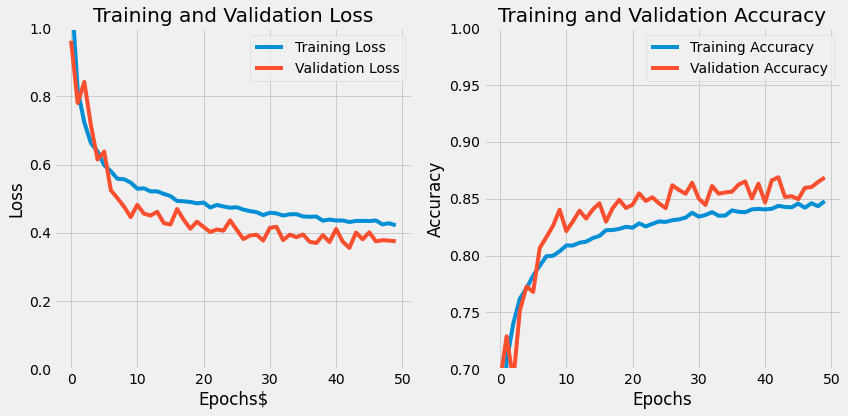

In [45]:
# Plot Learning Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(baseline_hist.history['loss'], label='Training Loss')
ax1.plot(baseline_hist.history['val_loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs$')
ax1.set_ylabel('Loss')
ax1.set_ylim(bottom=0.0, top=1.0)
ax1.legend()

ax2.plot(baseline_hist.history['accuracy'], label='Training Accuracy')
ax2.plot(baseline_hist.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(top=1.0, bottom=0.7)
ax2.legend()

plt.show()

In [46]:
# Evaluating Training and Testing Set
train = baseline.evaluate(x_train, y_train)
test  = baseline.evaluate(x_test, y_test)

# Creating a Logger to store all Evaluation Results
logger = pd.DataFrame(columns=['Train Loss', 'Train Acc', 'Test Loss', 'Test Acc'])
logger = logger.append(
    pd.Series(
        {
            'Train Loss': train[0],
            'Train Acc' : train[1],
            'Test Loss' : test[0],
            'Test Acc'  : test[1],
            'Test Percentage Error': "{:.2%}".format(1.0 - test[1])
        },
        name='ConvNet w/ Image Augmentation',))
logger

313/313 [==============================] - 1s 3ms/step - loss: 0.3377 - accuracy: 0.8809


,Train Loss,Train Acc,Test Loss,Test Acc,Test Percentage Error
ConvNet w/ Image Augmentation,0.293075,0.895017,0.337675,0.8809,11.91%


## Making Predictions

For softmax activation in the output layer, it outputs the probabilities of each class for every image. Therefore, Argmax is used to find the arguement that gives the largest probability among the all of the probabilities.

```python
y_pred_class = np.argmax(y_pred, axis=1)
```

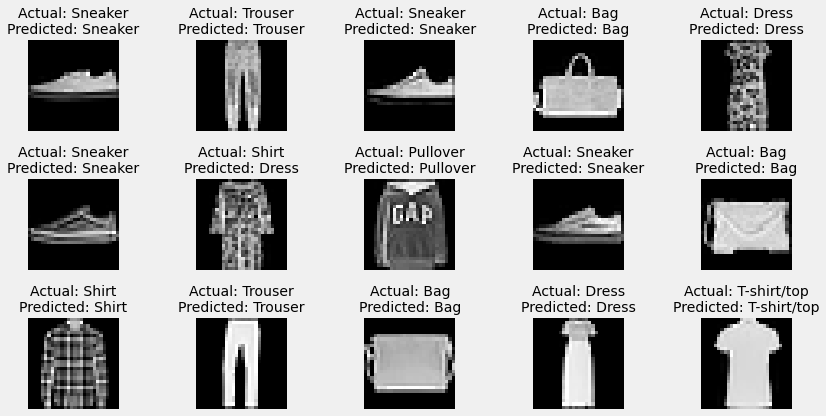

In [47]:
# Predict the values from the test dataset
y_pred = baseline.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_class = np.argmax(y_pred, axis = 1) 

w = 5
h = 3
fig = plt.figure(figsize=(12, 6), tight_layout=True)
for i in range(w*h):
  rand_idx = np.random.randint(0, len(x_test))
  ax = fig.add_subplot(h, w, i+1)
  ax.imshow((x_test[rand_idx] + 1) / 2)
  ax.axis('off')
  ax.set_title(f'Actual: {classes[y_test[rand_idx]]}\nPredicted: {classes[y_pred_class[rand_idx]]}', fontsize=14)
plt.show()


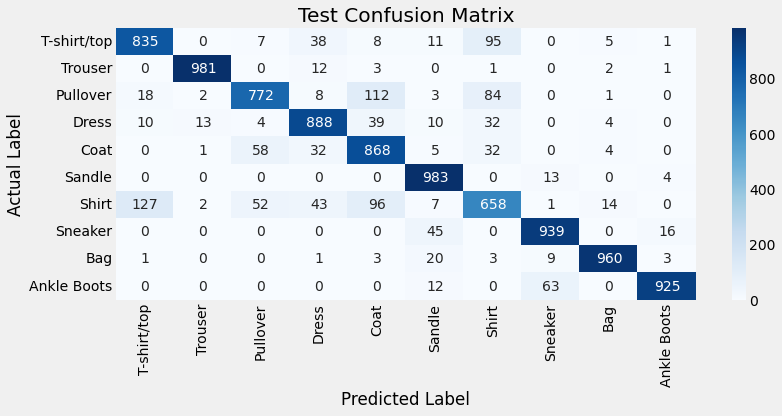

In [48]:
from sklearn.metrics import confusion_matrix
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_class)

sns.heatmap(confusion_mtx, cmap='Blues', annot=True, xticklabels=classes, yticklabels=classes, fmt='.3g')
plt.title('Test Confusion Matrix')
plt.xticks(rotation=90)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [49]:
from sklearn.metrics import classification_report
# print out classification report
print(classification_report(y_test, y_pred_class, target_names=classes))

              precision    recall  f1-score   support

 T-shirt/top       0.84      0.83      0.84      1000
     Trouser       0.98      0.98      0.98      1000
    Pullover       0.86      0.77      0.82      1000
       Dress       0.87      0.89      0.88      1000
        Coat       0.77      0.87      0.82      1000
      Sandle       0.90      0.98      0.94      1000
       Shirt       0.73      0.66      0.69      1000
     Sneaker       0.92      0.94      0.93      1000
         Bag       0.97      0.96      0.96      1000
 Ankle Boots       0.97      0.93      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



## Observations and Further Improvements

- Accuracy and Loss learning curves indicates no clear signs of the overfitting
  - Likely, due to Data Augmentation
- Validation loss performs better than training loss, indication of model being able to generalised well based on the training data
- Accuracy is relatively low compared to performances of [public notebooks](https://www.kaggle.com/zalando-research/fashionmnist/code)
- Higher confidence in predicting some of the classes (Trousers, Bag, Ankle Boots), while lower confidence in predicting some of the classes (Shirt, Coat, Pullover)
  - notice: better predictions on lower body clothes
- There are too many parameters in the fully connected layers (over 8 million parameters), which leads to longer training time and a larger likelihood to overfitting if wouldn't for the dropout layer.
  - gotta find a way to mitigate the number parameters in the fully connected layer

<br>

- Next focus should be on improving performance to hit above 90.0% accuracy (world-record is 96.91%)
- Use better and well known deeper network architectures (eg. ResNet, VGGNet, InceptionNet)
- Perhaps Hyperparameter Tuning to build a deeper network? Not really neccessary and computation inefficient

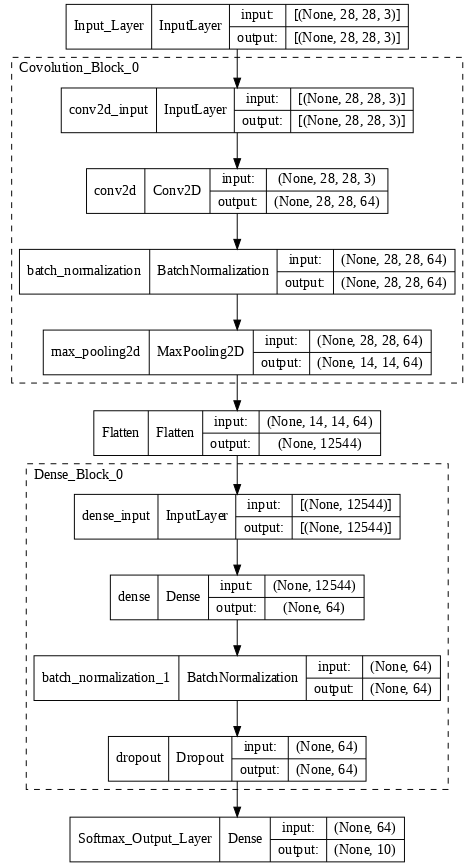

In [50]:
# Display Model Architecture in Notebook Output
from tensorflow.keras.utils import plot_model
plot_model(baseline, show_shapes=True, show_dtype=False,
    show_layer_names=True, expand_nested=True, dpi=70)